In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from scipy.special import logsumexp
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import sys
import math

sys.path.append('vbpi-torch/rooted')
from VIPR import VIPR

from dataManipulation import *
from treeManipulation import *
from utils import tree_summary, summary, summary_raw, get_support_info
from vbpi import VBPI

In [23]:
sns.set_style("whitegrid")  # Options: white, dark, whitegrid, darkgrid, ticks
sns.set_palette("muted")    # Options: deep, muted, bright, pastel, dark, colorblind

In [38]:
models = ["VBPI_10","VBPI_20","reinforce","reparam","VIMCO"]

colors = {"BEAST":plt.cm.tab10(0),
          "VBPI_10":plt.cm.tab10(1),
          "VBPI_20":plt.cm.tab10(2),
          "reinforce":plt.cm.tab10(3),
          "reparam":plt.cm.tab10(4),
          "VIMCO":plt.cm.tab10(5)}

linestyles = {"BEAST":"-",
              "VBPI_10":"--",
              "VBPI_20":"-.",
              "reinforce":":",
              "reparam":"--",
              "VIMCO":"-."}

data_sets = ["taxa_00008","taxa_00016","taxa_00032",
             "taxa_00064"]#,"taxa_00128","taxa_00256",
             #"taxa_00512"]

ntaxa = [8,16,32,64]#,128,256,512]

In [39]:
# load in VBPI
VBPI_runtimes = {}
VBPI_lbs = {}
VBPI_iters = {}
avg_runtimes = {}
CPD_params = {}

legend = []

for ds in data_sets:
    
    print(ds)
    
    avg_runtimes[ds] = {}
    VBPI_dir = '../results/'+ds+'/'
    VBPI_runtimes[ds] = {}
    VBPI_lbs[ds] = {}
    VBPI_iters[ds] = {}
    
    # get number of params
    data, taxa = loadData('../dat/'+ds+'/'+ds+'.nexus', 'nexus')
    mcmc_support_trees_dict, mcmc_support_trees_wts = summary('../dat/'+ds+'/'+ds+'_fixed_pop_support_short_run', 'nexus', burnin=250)
    rootsplit_supp_dict, subsplit_supp_dict = get_support_info(taxa, mcmc_support_trees_dict)
    emp_tree_freq = None
    sample_info = [0.0 for taxon in taxa]
    temp_model = VBPI(taxa, rootsplit_supp_dict, subsplit_supp_dict, data, pden=np.ones(4)/4., subModel=('JC', 1.0),
                 emp_tree_freq=emp_tree_freq, root_height_offset=0.0, clock_rate=1.0, psp=True,
                 sample_info=sample_info, coalescent_type='fixed_pop', clock_type='fixed_rate',
                 log_pop_size_offset=math.log(5.0))
    CPD_params[ds] = len(temp_model.tree_model.CPDs)
    
    for bs in ["10","20"]:

        VBPI_pref = "mcmc_vimco_%s_0.0001_psp_fixed_pop_fixed_rate_"%bs
        files = [x for x in os.listdir(VBPI_dir) if x.startswith(VBPI_pref)]
        files = [x for x in files if x.endswith(".pt")]
        file = max(files)

        VBPI_runtimes[ds][bs] = np.load(VBPI_dir+file.replace(".pt","_run_time.npy"))
        VBPI_lbs[ds][bs] = np.load(VBPI_dir+file.replace(".pt","_test_lb.npy"))
        VBPI_iters[ds][bs] = np.load(VBPI_dir+file.replace(".pt","_iters.npy"))
        
        avg_runtimes[ds]["VBPI_%s"%bs] = sum(VBPI_runtimes[ds][bs]) / VBPI_iters[ds][bs][-1]

taxa_00008
taxa_00016
taxa_00032
taxa_00064


In [40]:
# load in VIPR

optims = {}

for ds in data_sets:
    
    optims[ds] = {}
    
    for model in ["reinforce","reparam","VIMCO"]:
            
        optim_dir = '../results/'+ds+'/'
        optim_pref = ds+'_LogNormal_'+model+'_0.001_0'
        files = [x for x in os.listdir(optim_dir) if x.startswith(optim_pref)]
        
        if files:
            fname = optim_dir + max(files)
            with open(fname, 'rb') as f:
                optims[ds][model] = pickle.load(f)
            avg_runtimes[ds][model] = sum(optims[ds][model].run_times[1:]) / optims[ds][model].epochs[-1]
        else:
            optims[ds][model] = None
            avg_runtimes[ds][model] = np.nan

# Plot:
 - time / likelihood evaluation vs number of taxa
 - time / likelihood evaluation vs number of sites

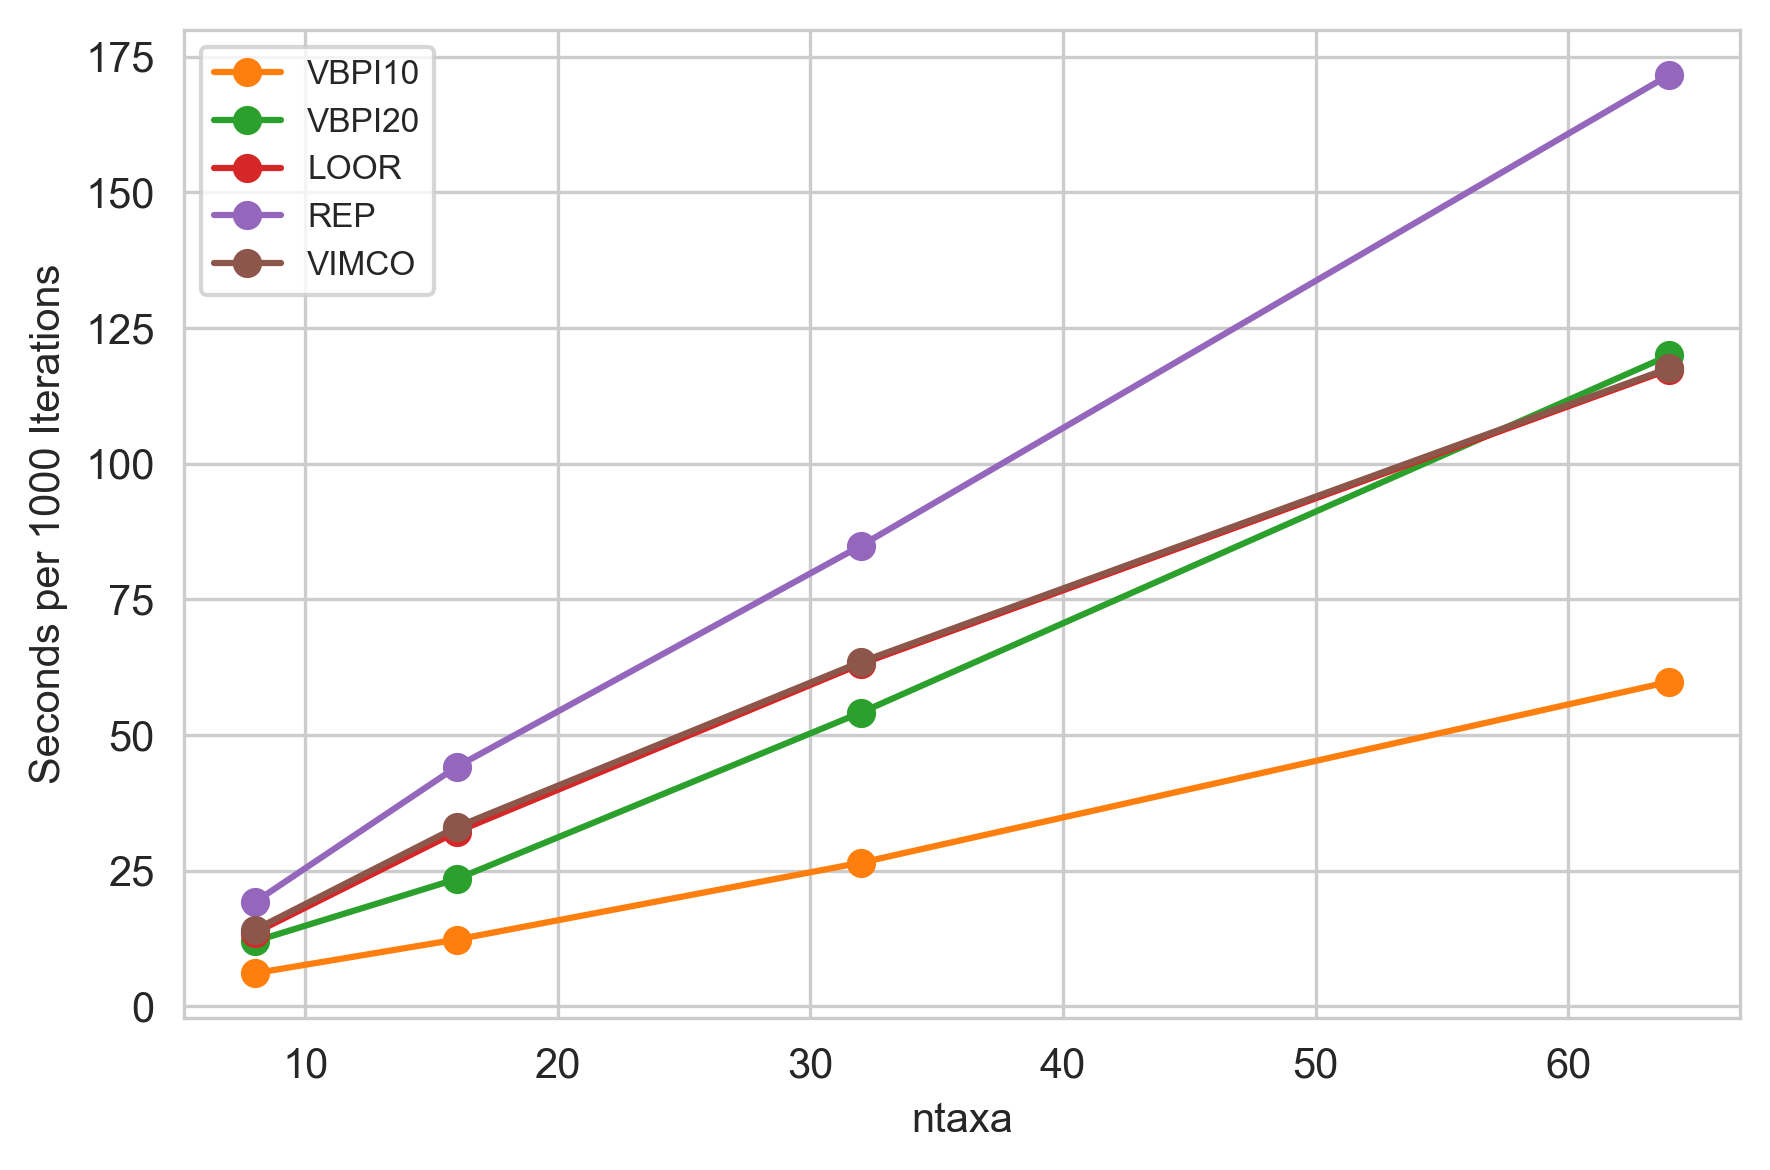

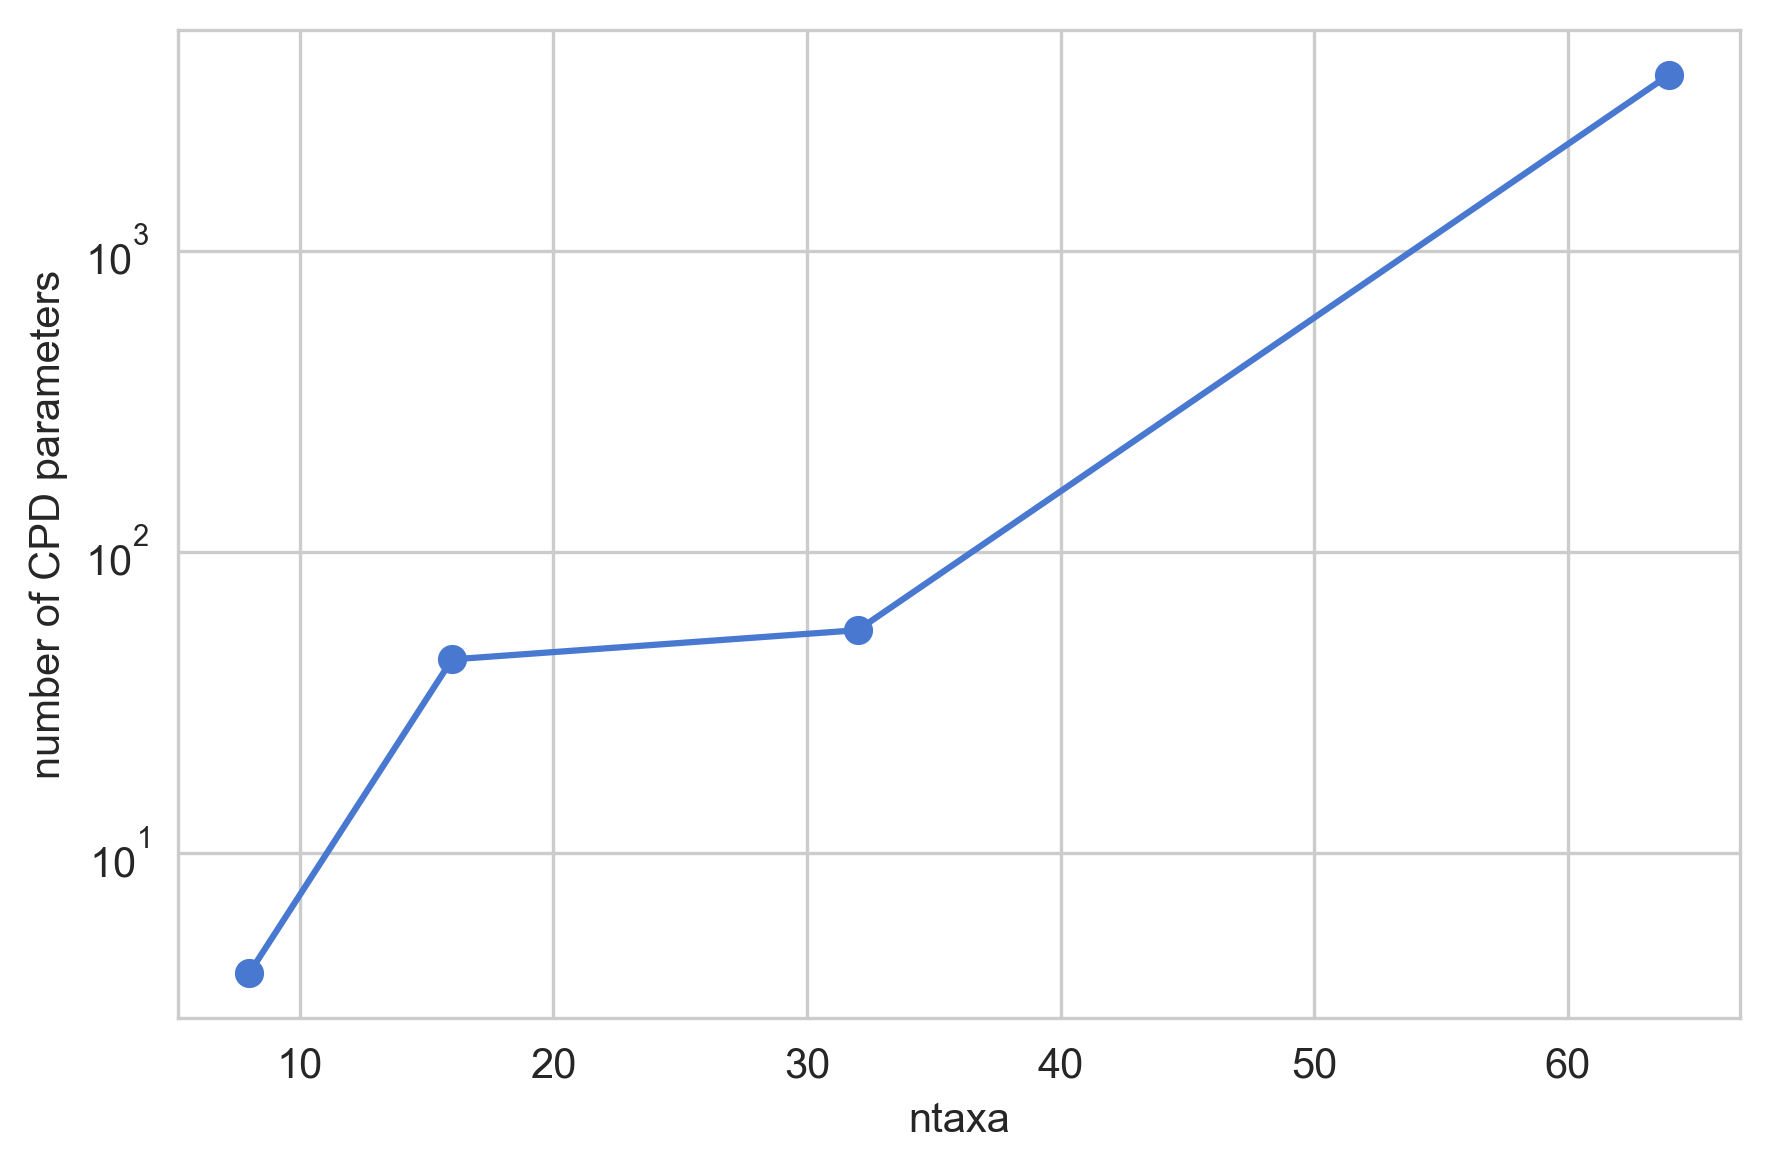

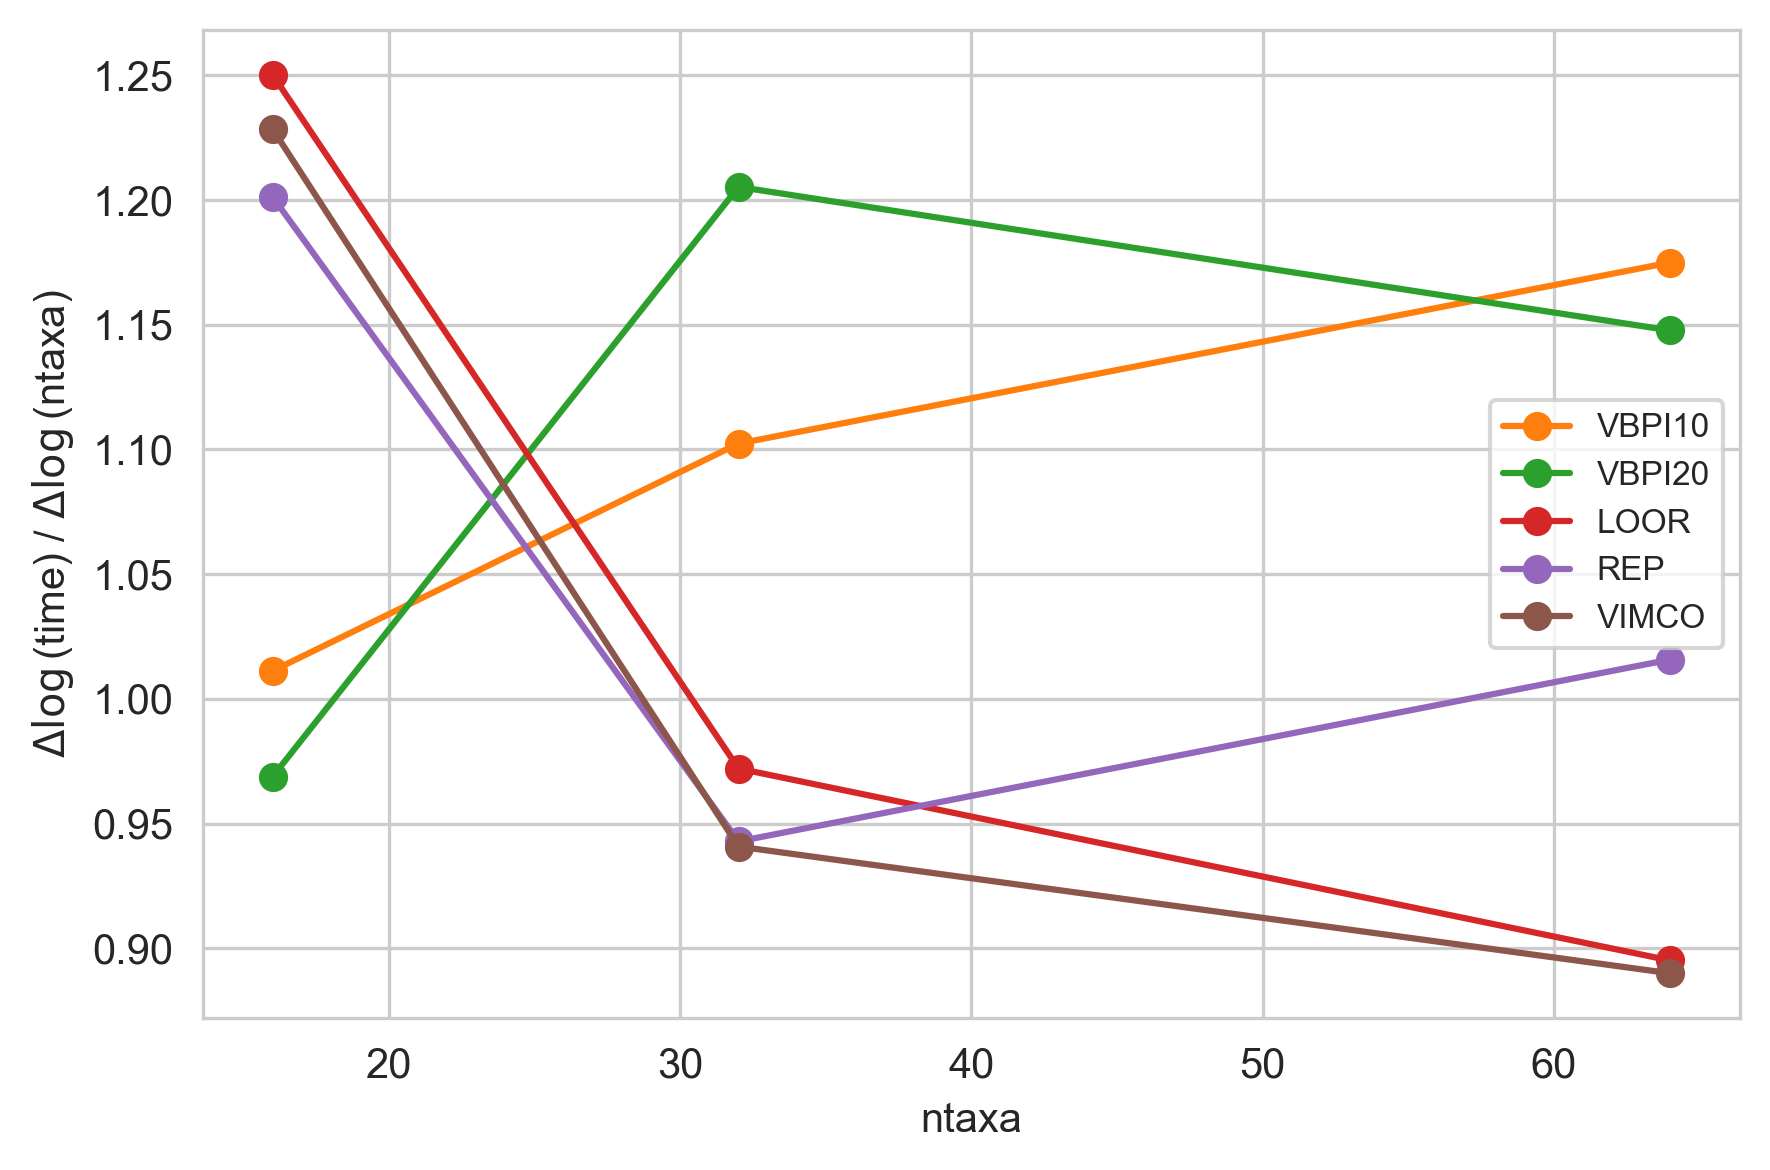

In [41]:
fig = plt.figure(figsize=(6, 4), dpi = 300)
fname = "../plt/sec_v_ntaxa.png"
    
for model in models:
    plt.plot(ntaxa,[1000*avg_runtimes[x][model] for x in data_sets],color = colors[model], marker = "o")

plt.ylabel("Seconds per 1000 Iterations")
plt.xlabel("ntaxa")
plt.legend(["VBPI10","VBPI20","LOOR","REP","VIMCO"],prop={'size': 8})
#plt.yscale("log")
#plt.xscale("log")
plt.tight_layout()
plt.savefig(fname, dpi = 300)
plt.show()

###

fig = plt.figure(figsize=(6, 4), dpi = 300)
fname = "../plt/CPD_v_ntaxa.png"
plt.plot(ntaxa,list(CPD_params.values()),marker = "o")

plt.ylabel("number of CPD parameters")
plt.xlabel("ntaxa")
plt.yscale("log")
plt.tight_layout()
plt.savefig(fname, dpi = 300)
plt.show()

###

def dlogy_dlogx(y,x):
    return [(np.log(y[i+1])-np.log(y[i])) / (np.log(x[i+1])-np.log(x[i])) for i in range(len(y)-1)]

fig = plt.figure(figsize=(6, 4), dpi = 300)
fname = "../plt/dydx_v_ntaxa.png"

for model in models:
    plt.plot(ntaxa[1:],dlogy_dlogx([avg_runtimes[x][model] for x in data_sets],ntaxa),color = colors[model], marker = "o")

plt.ylabel(r"$\Delta \log$(time) / $\Delta \log$(ntaxa)")
plt.xlabel("ntaxa")
plt.legend(["VBPI10","VBPI20","LOOR","REP","VIMCO"],prop={'size': 8})
plt.tight_layout()
plt.savefig(fname, dpi = 300)
plt.show()

In [42]:
print(ntaxa)
for model in models:
    print(model)
    print([1000*avg_runtimes[x][model] for x in data_sets])

print("")
print(list(CPD_params.values()))

[8, 16, 32, 64]
VBPI_10
[np.float64(6.122419357299805), np.float64(12.34061336517334), np.float64(26.49630045890808), np.float64(59.82554507255554)]
VBPI_20
[np.float64(11.999128341674805), np.float64(23.48544669151306), np.float64(54.15401291847229), np.float64(119.98798990249634)]
reinforce
[13.524703979492188, 32.17215855916341, 63.10910542805989, 117.36440049277412]
reparam
[19.207528167300755, 44.16515482796563, 84.89880084991455, 171.6605167918735]
VIMCO
[14.114782280392117, 33.07206524742974, 63.482473956214065, 117.63976256052653]

[4, 44, 55, 3826]
